In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# Import data
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [2]:
# Helper functions for creating weight variables
def weight_variable(shape):
    """weight_variable generates a weight variable of a given shape."""
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    """bias_variable generates a bias variable of a given shape."""
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [3]:
# Convolutional neural network functions
def conv2d(x, W):
    """conv2d returns a 2d convolution layer with full stride."""
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    """max_pool_2x2 downsamples a feature map by 2X."""
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [4]:
# Model Inputs
x = tf.placeholder(tf.float32, [None, 784])### MNIST images enter graph here ###
y_ = tf.placeholder(tf.float32, [None, 10])### MNIST labels enter graph here ###

# Define the graph
x_2d = tf.reshape(x,[-1,28,28,1])
#[filter_height, filter_width, in_channels, out_channels]
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])
conv1_out = conv2d(x_2d,W_conv1) + b_conv1
relu1_out = tf.nn.relu(conv1_out)
pool1_out = max_pool_2x2(relu1_out)
W_conv2 = weight_variable([5,5,32,64])
b_conv2 = bias_variable([64])
conv2_out =conv2d(pool1_out,W_conv2) + b_conv2
relu2_out = tf.nn.relu(conv2_out)
pool2_out = max_pool_2x2(relu2_out)
#flatten for the FC layer
fc1_in = tf.reshape(pool2_out,[-1,64*49])
W_fc1 = weight_variable([64*49,1024])
b_fc1 = bias_variable([1024])
fc1_out = tf.nn.relu(tf.matmul(fc1_in,W_fc1) + b_fc1)
W_fc2 = weight_variable([1024,10])
b_fc2 = bias_variable([10])
fc2_out = tf.matmul(fc1_out,W_fc2) + b_fc2
y_conv = fc2_out

# Loss
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

# Evaluation
correct_prediction = tf.equal(tf.argmax(y_conv, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [15]:
# Optimizers: Try out a few different parameters for SGD and SGD momentum
train_step_SGD = tf.train.GradientDescentOptimizer(learning_rate=0.001).minimize(cross_entropy)
train_step_momentum = tf.train.MomentumOptimizer(learning_rate=0.001, momentum=0.9).minimize(cross_entropy)
train_step_ADAM = tf.train.AdamOptimizer().minimize(cross_entropy)

# Op for initializing all variables
initialize_all = tf.global_variables_initializer()

In [16]:
def train_CNN(train_step_optimizer, iterations=4000):
    with tf.Session() as sess:
        # Initialize (or reset) all variables
        sess.run(initialize_all)
        
        # Initialize arrays to track losses and validation accuracies
        valid_accs = [] 
        losses = []
        
        for i in range(iterations):
            # Validate every 250th batch
            if i % 250 == 0:
                validation_accuracy = 0
                for v in range(10):
                    batch = mnist.validation.next_batch(50)
                    validation_accuracy += (1/10) * accuracy.eval(feed_dict={x: batch[0], y_: batch[1]})
                print('step %d, validation accuracy %g' % (i, validation_accuracy))
                valid_accs.append(validation_accuracy)
                
            # Train    
            batch = mnist.train.next_batch(50)
            loss, _ = sess.run([cross_entropy, train_step_optimizer], feed_dict={x: batch[0], y_: batch[1]})
            losses.append(loss)
            
        print('test accuracy %g' % accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels}))
        
    return valid_accs, losses

In [17]:
print("SGD:")
valid_accs_SGD, losses_SGD = train_CNN(train_step_SGD)
print("Momentum:")
valid_accs_momentum, losses_momentum = train_CNN(train_step_momentum)
print("ADAM:")
valid_accs_ADAM, losses_ADAM = train_CNN(train_step_ADAM)

SGD:
step 0, validation accuracy 0.092
step 250, validation accuracy 0.788
step 500, validation accuracy 0.876
step 750, validation accuracy 0.886
step 1000, validation accuracy 0.882
step 1250, validation accuracy 0.924
step 1500, validation accuracy 0.934
step 1750, validation accuracy 0.942
step 2000, validation accuracy 0.938
step 2250, validation accuracy 0.94
step 2500, validation accuracy 0.938
step 2750, validation accuracy 0.934
step 3000, validation accuracy 0.926
step 3250, validation accuracy 0.934
step 3500, validation accuracy 0.944
step 3750, validation accuracy 0.944
test accuracy 0.9518
Momentum:
step 0, validation accuracy 0.126
step 250, validation accuracy 0.904
step 500, validation accuracy 0.964
step 750, validation accuracy 0.964
step 1000, validation accuracy 0.952
step 1250, validation accuracy 0.97
step 1500, validation accuracy 0.982
step 1750, validation accuracy 0.972
step 2000, validation accuracy 0.97
step 2250, validation accuracy 0.982
step 2500, valida

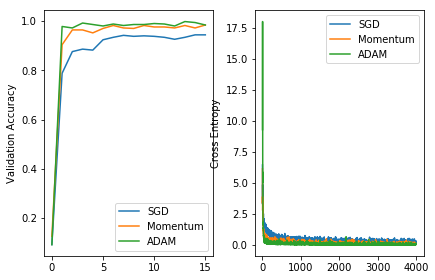

In [18]:
fig, ax = plt.subplots(1, 2)
fig.tight_layout()

ax[0].plot(valid_accs_SGD)
ax[0].plot(valid_accs_momentum)
ax[0].plot(valid_accs_ADAM)

ax[0].set_ylabel('Validation Accuracy')
ax[0].legend(['SGD', 'Momentum', 'ADAM'], loc='lower right')

ax[1].plot(losses_SGD)
ax[1].plot(losses_momentum)
ax[1].plot(losses_ADAM)

ax[1].set_ylabel('Cross Entropy')
ax[1].legend(['SGD', 'Momentum', 'ADAM'], loc='upper right')
# ax[1].set_ylim([0,1.5])  # <- Use this to change y-axis limits